In [2]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(2)
import csv
from __future__ import division
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
import sklearn.preprocessing as preprocessing
from random import randint
from numpy import array
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
from keras.models import Sequential, Model
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding, Input, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
# from spektral.layers import GCNConv, GlobalSumPool
# from spektral.data.loaders import DisjointLoader
# from spektral.data import Dataset
# from spektral.utils import normalized_laplacian
# from spektral.layers.ops import sp_matrix_to_sp_tensor
np.set_printoptions(threshold=sys.maxsize)

2023-12-07 13:02:14.300118: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-07 13:02:14.322165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-07 13:02:14.322185: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-07 13:02:14.322742: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-07 13:02:14.326681: I tensorflow/core/platform/cpu_feature_guar

## Utils

In [3]:
# ============================== Utils =========================================

def plot_loss_accuracy(history):
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    if ('val_categorical_accuracy' in history.history.keys()):
        plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    if ('val_loss' in history.history.keys()):
        plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

def adBits(x, x2, y, seqsize=100):
   for i in range(x.shape[0]):
      #print(' for each train sample  ... ', i)
      loop = seqsize
      j = 0
      for loop in range(seqsize):     
          #print(' for each node ... ', j)
          adBits_1 = int(x[i][2*loop])
          #Get the next LONG since each node now has 2 LONGs for adj edges
          adBits_2 = int(x[i][2*loop+1])
          # Uncomment below if you want invalid nodes to not feed to NN before any valid nodes
          #if (adBits_1==0 and adBits_1==0 and loop!=seqsize-1):              
          #    y[i][j] = y[i][loop+1] 
          #    continue
          if (adBits_1):
              #print adBits
              for k in range(0,64):
                  bit = adBits_1 & 1
                  #print ( ' adBits&1 = ',  bit )
                  # Uncomment below if you want new nodes to only have adjacency to earlier nodes
                  if ( bit == 1):
                  #if ( bit == 1 and k<j):
                      x2[i][j][k] = 1
                      #print x2[i-1][j-1][k-1]
                  else:
                      x2[i][j][k] = 0
                      #print x2[i-1][j-1][k-1]
                  adBits_1 >>= 1
              x2[i][j][j] = 1 

          if (adBits_2):   
              #print adBits
              for k in range(64,100):
                  bit = adBits_2 & 1
                  #print ( ' adBits&1 = ',  bit )
                  if ( bit == 1):
                  #if ( bit == 1 and k<j):
                      x2[i][j][k] = 1
                      #print x2[i-1][j-1][k-1]
                  else:
                      x2[i][j][k] = 0
                      #print x2[i-1][j-1][k-1]
                  adBits_2 >>= 1
              x2[i][j][j] = 1
          j = j+1
   return x2, y

def updateLabelBits(x, y, seqsize=100):
    for i in range(x.shape[0]):
        #print(' for each train sample  ... ', i)
        label_dict = {}
        label_num = 1
        for j in range(seqsize):
            if (x[i][j][j] == 0):
                y[i][j] = 0
            else:
                if y[i][j] in label_dict:
                    y[i][j] = label_dict[y[i][j]]
                else:
                    label_dict[y[i][j]] = label_num
                    y[i][j] = label_num
                    label_num = label_num + 1
    return y

# ============================== Post Process ==================================

csv_rows = []

def post_process (x2_pred, predicted, seqsize=100):
    #Calculate the number of edges which will require correction
    invCols = 0
    edges = 0
    for i in range(x2_pred.shape[0]):
        for j in range(seqsize): # row
            for k in range(j): # col
                adj = x2_pred[i][j][k]
                if (adj == 1):
                    edges += 1
                    if (np.argmax(predicted[i][j]) == np.argmax(predicted[i][k])):
                        invCols += 1
                        
    print('Total No of edges ', edges)
    print('# of edges with invalid coloring ', invCols)
    print('Total percentage of edges with invalid colors ', invCols/edges)

def post_process_chromatic (x2_pred, predicted, seqsize=100):  
    colors_list_list = []
    for i in range(x2_pred.shape[0]):
        colors_list = []
        for j in range(seqsize):
            # Valid nodes will have below set to 1 so check the color 
            # assignment of those nodes only
            if (x2_pred[i][j][j] != 0):
                colors_list.append(np.argmax(predicted[i][j]))
        print('Colors list of graph ', i, ' is  \n', colors_list)
        chromatic_number = len(set(colors_list))
        print('Chromatic number of graph ', i, ' is  ', chromatic_number)
        colors_list_list.append(colors_list)
    return colors_list_list

def create_csv_rows (graph_name, colors_list_list_before_correction, 
                     colors_list_list_after_correction):    
    for i in range(len(colors_list_list_before_correction)):
        row = [graph_name, i, len(set(colors_list_list_before_correction[i])), 
               len(set(colors_list_list_after_correction[i]))]        
        csv_rows.append(row)

def post_process_correction (x2_pred, predicted, colors_list_list, seqsize=100): 
  totInvCols = 0
  totEdges = 0

  for i in range(x2_pred.shape[0]):
      #maxcol = max(xpredicted[i])
      maxcol = max(colors_list_list[i])
      #print(maxcol)
      #mcol = maxcol[0]
      maxorigcol = maxcol
      mcolnew = maxcol
      #print('Maxcol = ',maxcol[0])
      #print(' ... FOR SAMPLE  ... ', i)
      invCols = 0
      edges = 0;
      newCol = 500

      for j in range(seqsize):
          #print(' ... ... FOR EACH NODE ... ...', j)
          for k in range(j):
              #print(' ... ... ... for each adjacency  ... ... ...', k)
              adj = x2_pred[i][j][k]
              #There is an edge
              if ( adj == 1 ):
                  edges += 1
                  if ( np.argmax(predicted[i][j]) == np.argmax(predicted[i][k]) ):                   
                      col_j = np.argmax(predicted[i][j])
                      col_k = np.argmax(predicted[i][k])
                      invCols += 1

                      #Check whether we can give one of the existing colors
                      foundfinalcol = 0
                      for  y in range(1,maxcol+1):
                          #print('Check for COLOR NO ... ', y)
                          if ( foundfinalcol == 1 ) :
                              #print('FOUND COLOR ALREADY  ... leave the loop')
                              break

                          foundcol = 0
                          #Check the adjacent nodes of j
                          #for  z in range(j):
                          for z in range(seqsize):
                              if j!=z:
                                  if  (   ((x2_pred[i][j][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                      or  ((x2_pred[i][z][j] == 1) and (np.argmax(predicted[i][z]) == y))
                                      ):
                                      #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                      foundcol = 1
                                      #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                      break

                          #Finished checking the adjacent nodes of j
                          #Color y is not used by any of j's neighbours
                          #print('[1] Finished Checking the adjacent node of ... ',j,' ... foundcol = ',foundcol)
                          if ( foundcol == 0 ) :
                              #assign any prediction > 1
                              predicted[i][j][y] = 2
                              #print('[1] Reuse color ', y, ' for node ', j)
                              foundfinalcol = 1

                          else :
                              foundcol = 0                                                            
                              #Check the adjacent nodes of k
                              for z in range(seqsize):
                                  if k!=z:
                                      if  (   ((x2_pred[i][k][z] == 1) and (np.argmax(predicted[i][z]) == y))
                                          or  ((x2_pred[i][z][k] == 1) and (np.argmax(predicted[i][z]) == y))
                                          ):
                                          #print('[1] Adjacent node ... from ',j, '-->', z, 'color = ',xpredicted[i][z][0] )
                                          foundcol = 1
                                          #print('[1] Found Color ', y, ' for node ', z, 'from node ', j )
                                          break
                              #Color y is not used by any of k's neighbours
                              if ( foundcol == 0 ) :
                                  #assign any prediction > 1
                                  predicted[i][k][y] = 2
                                  #print('[2] Reuse color ', y, ' for node ', k )
                                  foundfinalcol = 1

                      # Could not color using an existing color
                      # Get a new color from 500 onwards OR use from the new 500 color number series
                      if ( foundfinalcol == 0 ) :
                           #newCol += 1
                           mcolnew += 1
                           #assign any prediction > 1
                           predicted[i][k][mcolnew] = 2
                           maxcol +=1
                           #print('Use new color ', mcolnew, ' for node ', k)

  return predicted



## Data

In [4]:
seqsize = 100

eseq1 = pd.read_csv("train_data.csv",header=None,low_memory=False)

eseq  = eseq1

columns = eseq.columns.tolist()
#2 entries for each node's adjacency 
edata = eseq[columns[1:3*seqsize+1]]
#get the adj edges
edataadj = eseq[columns[1:2*seqsize+1]]
#get the colors
edatacols = eseq[columns[2*seqsize+1:3*seqsize+1]]
#chromatic number
ncols = eseq[columns[0:1]]

#Now make x_train a 2-dim array
#As we have read the adjacency row as bits
#and we now want to make them into features
#x_train and x2_train have different shapes as 2 LONGs are present in x_train
#So use y_train.shape[1] instead of x_train.shape[1]
#x2_train = np.zeros((x_train.shape[0],y_train.shape[1],128))
from keras.utils import to_categorical

x_train, y_train = np.array(edataadj), np.array(edatacols)
x2_train = np.zeros((x_train.shape[0], y_train.shape[1], seqsize))
x2_train, y_train = adBits(x_train, x2_train, y_train)
y_train = updateLabelBits(x2_train, y_train)
y2_train = to_categorical(y_train, num_classes=101)
print(x2_train.shape)
print(y2_train.shape)


(8158, 100, 100)
(8158, 100, 101)


## Train

In [5]:
seqsize = 100
seq_inputs = layers.Input(shape=(seqsize,100,), dtype='float32')
encoder = layers.Bidirectional(layers.LSTM(512, return_sequences=True, name="lstm_1"))(seq_inputs)
encoder = layers.Dropout(0.2)(encoder)
encoder = layers.Bidirectional(layers.LSTM(256, return_sequences=True, name="lstm_2"))(encoder)
encoder = layers.Dropout(0.2)(encoder)
decoder = layers.Bidirectional(layers.LSTM(128, return_sequences=True, name="lstm_3"))(encoder)
decoder = layers.Dropout(0.2)(decoder)
decoderoutputs = layers.TimeDistributed(layers.Dense(101,activation="softmax"))(decoder)
model = tf.keras.Model(inputs=seq_inputs, outputs=decoderoutputs)

2023-12-07 13:02:30.265323: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 13:02:30.283824: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-07 13:02:30.283972: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
n_epoch=80
n_batch=64

#model.compile(optimizer="adam", loss="mean_squared_error", metrics=['MeanAbsoluteError'])
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100)]        0         
                                                                 
 bidirectional (Bidirection  (None, 100, 1024)         2510848   
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 100, 1024)         0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 100, 512)          2623488   
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 100, 512)          0         
                                                                 
 bidirectional_2 (Bidirecti  (None, 100, 256)          656384

In [7]:
history = model.fit(x2_train, y2_train, epochs=n_epoch, batch_size=n_batch, verbose=2, shuffle=True)

Epoch 1/80


2023-12-07 13:02:42.478969: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2023-12-07 13:02:43.577226: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f489018e920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-12-07 13:02:43.577249: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2023-12-07 13:02:43.581373: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1701972163.645175   22321 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 - 10s - loss: 1.0938 - categorical_accuracy: 0.6340 - 10s/epoch - 80ms/step
Epoch 2/80
128/128 - 6s - loss: 0.8813 - categorical_accuracy: 0.6570 - 6s/epoch - 44ms/step
Epoch 3/80
128/128 - 6s - loss: 0.8511 - categorical_accuracy: 0.6638 - 6s/epoch - 48ms/step
Epoch 4/80
128/128 - 6s - loss: 0.8281 - categorical_accuracy: 0.6702 - 6s/epoch - 47ms/step
Epoch 5/80
128/128 - 6s - loss: 0.8204 - categorical_accuracy: 0.6718 - 6s/epoch - 47ms/step
Epoch 6/80
128/128 - 6s - loss: 0.8113 - categorical_accuracy: 0.6732 - 6s/epoch - 45ms/step
Epoch 7/80
128/128 - 6s - loss: 0.8064 - categorical_accuracy: 0.6745 - 6s/epoch - 46ms/step
Epoch 8/80
128/128 - 6s - loss: 0.7968 - categorical_accuracy: 0.6772 - 6s/epoch - 46ms/step
Epoch 9/80
128/128 - 5s - loss: 0.7905 - categorical_accuracy: 0.6790 - 5s/epoch - 43ms/step
Epoch 10/80
128/128 - 6s - loss: 0.7829 - categorical_accuracy: 0.6814 - 6s/epoch - 43ms/step
Epoch 11/80
128/128 - 5s - loss: 0.7767 - categorical_accuracy: 0.6834 - 5s/ep

In [8]:
model.save("tensorflow_version.h5")

/home/chrenx/anaconda3/envs/eecs583/lib/python3.9/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


dict_keys(['loss', 'categorical_accuracy'])


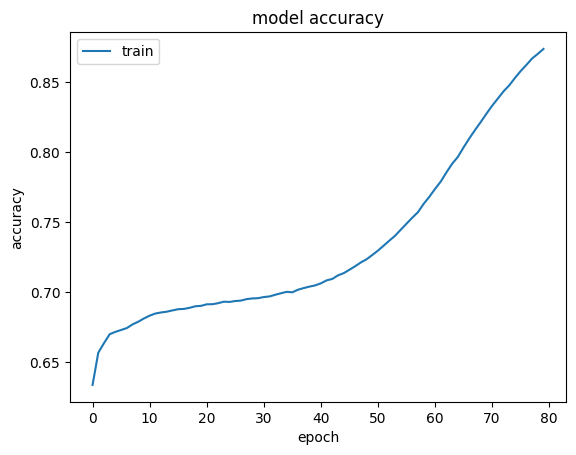

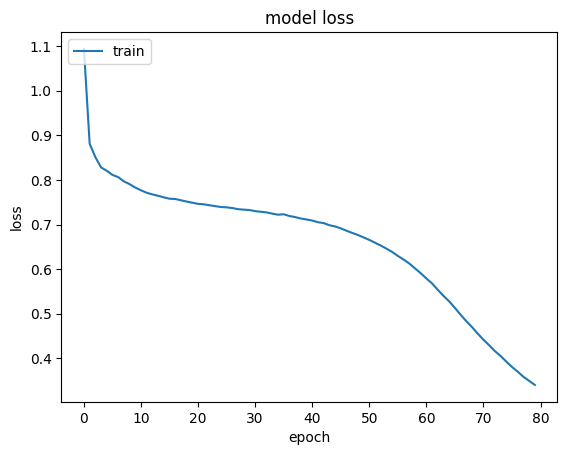

In [10]:
plot_loss_accuracy(history)